# Uber: Estimating Beta (SCL vs. Comparables)

#### Aidan Cremins, Peyton Lewis, Joe Morris, Amrit Sandhu

## Part I: SCL Analysis

### Necessary Imports

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

### Assumptions

<li>Granularity: Weekly<br>
<li>Timeframe: Two years<br>
<li>Risk Free Rate: 0% (Performing Historical SCL Analysis)
<li>Regression Assumptions: Normality, Homoscedasticity, No Autocorrelation, No Multicollinearity, Linear Relationship

### Read in Data

In [3]:
uber_data = pd.read_csv('UBER.csv')
uber_data['Market Risk Premium'] = uber_data['Adj_Close_Market'].pct_change(1) - uber_data['rf_rate']
uber_data['Uber Risk Premium'] = uber_data['Adj_Close_Uber'].pct_change(1) - uber_data['rf_rate']
uber_data = uber_data.fillna(0)
uber_data = uber_data.drop(['URP', 'MRP'], axis=1)
uber_data

,Adj_Close_Uber,Adj_Close_Market,rf_rate,Market Risk Premium,Uber Risk Premium
0,33.720001,337.360901,0,0.000000,0.000000
1,36.750000,335.894012,0,-0.004348,0.089858
2,33.410000,317.204102,0,-0.055642,-0.090884
3,44.869999,340.148834,0,0.072334,0.343011
4,47.610001,347.861816,0,0.022675,0.061065
...,...,...,...,...,...
101,27.820000,367.950012,0,-0.041754,-0.128719
102,26.500000,357.179993,0,-0.029270,-0.047448
103,28.070000,362.790009,0,0.015706,0.059245
104,24.709999,357.630005,0,-0.014223,-0.119701


In [4]:
#define predictor and response variables
y = uber_data['Uber Risk Premium'].iloc[1:]
x = uber_data['Market Risk Premium'].iloc[1:]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Uber Risk Premium   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     37.67
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           1.58e-08
Time:                        14:12:37   Log-Likelihood:                 130.63
No. Observations:                 105   AIC:                            -257.3
Df Residuals:                     103   BIC:                            -252.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0008    

### Beta Analysis

In [5]:
uber_beta = model.params[1]
uber_tstat_0 = model.tvalues[1]
uber_se = model.bse[1]

print('Uber Beta: ', uber_beta)
print('Uber T-stat (Null of 0): ', uber_tstat_0)
print('Uber SE of Beta Estimate: ', uber_se)

Uber Beta:  1.610413296029547
Uber T-stat (Null of 0):  6.137693569814905
Uber SE of Beta Estimate:  0.2623808565402382


To test whether the coeffient is statistically signicantly different from the market's Beta of 1, we run a Hypothesis Test with the null hypothesis that Uber's Beta is equal to 1.

In [6]:
uber_t_stat = (uber_beta - 1) / uber_se
print('Uber T-stat (Null of 1): ', uber_t_stat)

Uber T-stat (Null of 1):  2.3264399090637746


Because the relevant t statisitc is 2.326 and there are enough data points (n = 105) to assume that the Student T Distribution is well-approximated by the Normal curve, a critical t value of 1.96 is used. This indicates that Uber's Beta is statisically different from the market Beta of 1 and therefore carries more risk than a well diversified portfolio.

### Confidence Interval of Beta

In [7]:
lower_bound = uber_beta - 1.96 * uber_se
upper_bound = uber_beta + 1.96 * uber_se
print('95% Confidence Interval: [{:.4f}, {:.4f}]'.format(lower_bound, upper_bound))

95% Confidence Interval: [1.0961, 2.1247]


When computing the upper and lower bound on the Beta estimate for Uber using the critical t-value of 1.96, the bound is found to be (1.096, 2.125), which differs slightly from the OLS output, which interpolated the exact critical t-statistic using the sample size (instead of approximating with the Normal curve). This 95% confidence interval was computed by taking the product of the critical t-value of 1.96 and the standard error of the Beta estimate of 0.262 and adding and subtracting it from the Beta estimate of 1.610 (Confidence interval = Beta +- t_critical * standard error of Beta). The critical t value of 1.96 is used because in a normal distribution, 95% of the area under the curve is contained within 1.96 standard deviations on either side of the mean. This will allow us to obtain a 95% confidence interval on our Beta estimate for Uber. <br><br>
This interval, centered at the Beta estimate for Uber, indicates that if this process were repeated many times, 95% of the generated estimates for Uber's Beta would fall within this interval. This Beta was computed using weekly returns for two years. This level of granularity provides a sample size of 105 data points, which would lead to a much tighter interval around Beta than 2 years of monthly returns, for example. This is a function of the sample size, because as sample size increases, the standard error of the Beta estimate decreases, and its corresponding confidence interval will tighten as well.

### Security Characteristic Line

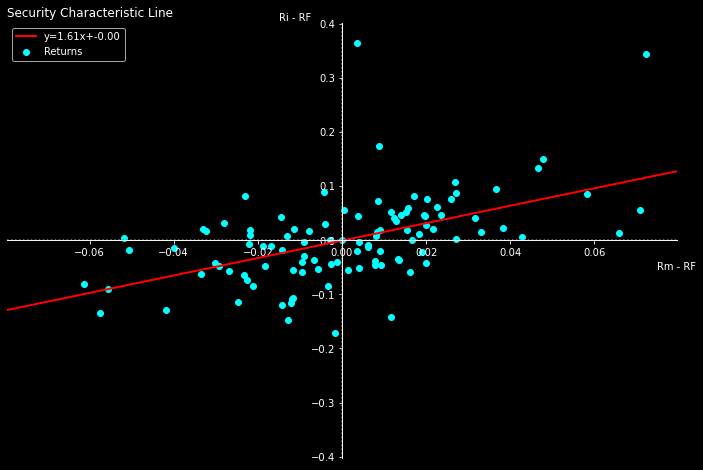

In [8]:
x = uber_data['Market Risk Premium']
y_actual = uber_data['Uber Risk Premium']
    
x_all = np.linspace(-4, 4, 100)
y = model.params['const'] + model.params['Market Risk Premium'] * x_all


x_range = max(abs(max(x)), abs(min(x))) + max(abs(max(x)), abs(min(x))) * .1
y_range = max(abs(max(y_actual)), abs(min(y_actual))) + max(abs(max(y_actual)), abs(min(y_actual))) * .1
max_range = max(x_range, y_range)

plt.style.use('dark_background')
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_position('zero')
ax.spines['top'].set_position('zero')
ax.yaxis.set_label_coords(.53, 1)
ax.xaxis.set_label_coords(1, .53)
plt.scatter(x=x, y=y_actual, label='Returns', color='cyan')
plt.plot(x_all, y, color='red', linewidth=2, \
    label='y={:.2f}x+{:.2f}'.format(model.params['Market Risk Premium'],model.params['const']))
plt.axhline(0, linestyle=':', color='grey')
plt.axvline(0, linestyle=':', color='grey')
plt.xlabel('Rm - RF')
ax.xaxis.set_label_coords(1, 0.45)
plt.ylabel('Ri - RF', rotation = 360)
ax.yaxis.set_label_coords(0.43, 1)
plt.xlim(-x_range, x_range)
plt.ylim(-y_range, y_range)
plt.legend(loc='best')
plt.title('Security Characteristic Line ', loc='left')
    
plt.show()
    

### Check Regresssion Assumptions 

#### 1. Normality of Residuals

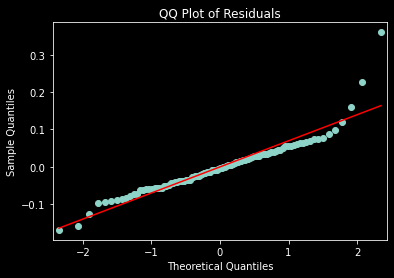

In [9]:
#Check normality of residuals via a Q-Q plot
residuals = model.resid
fig = sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

When residuals are normally distributed, the data points will follow the diagonal line. We see from the plot above that aside from a few observations in the extreme theoretical quartiles (the x-values), that the data points do indeed follow the red diagonal. Thus, we can feel confident that the residuals are normally distributed.

#### 2. Homoscedasticity

Text(0.5, 1.0, 'Residuals vs Fitted Values')

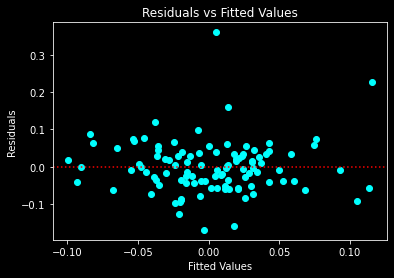

In [10]:
#Plot the fitted values against the model residuals to check for homoscedasticity
plt.scatter(x=model.fittedvalues, y=residuals, color='cyan')
plt.axhline(0, linestyle=':', color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

To check for homoscedasticity, we can plot the fitted values of the model along the x-axis and the residuals corresponding to each fitted value along the y-axis. If homoscedasticity holds, we should expect to see an even distribution in the scatter of points across all fitted values. While there a few outlier points, the scatter of residuals remains pretty consistent around the y=0 line which is what we want to see. Therefore, the homoscedasticity assumption is met.

#### 3. No Autocorrelation

In [33]:
# test autocorrelation using Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson

print('Durbin-Watson Test Statistic: ', durbin_watson(residuals).round(4))

Durbin-Watson Test Statistic:  2.1588


Autocorrelation deals with the independence of observations (i.e. does the value of an observation depend on the value of another observation). This is particularly problematic with time-series data since values in a prior period often influence later values. One way to test autocorrelation is via the Durbin-Watson test. If the Durbin-Watson test statistic is between 1.5-2.5, then the data is not significantly autocorrelated (via https://help.sap.com/saphelp_SCM700_ehp02/helpdata/en/e8/3cc95360267614e10000000a174cb4/content.htm?no_cache=true#:~:text=The%20Durbin%2DWatson%20statisticlies%20in,acceptable%20range%20is%201.50%20%2D%202.50.). The Durbin-Watson test statistic is conveniently provided in the regression output above where we see that it's 2.159. Interestingly, although we're working with time-series data, the Durbin-Watson test statistic is in the appropriate range and there's no significant autocorrelation problem. This assumption is met.

#### 4. No Multicollinearity

Multicollinearity is a problem when doing multiple linear regression and predictors are highly correlated with one another. Since we're doing a simple linear regression of Uber's risk premium against the market's risk premium, we don't have to worry about multicollinearity and the assumption is met by default.

#### 5. Linear Relationship

This assumption deals with the idea that the underlying data can be appropriately be modeled by a linear model and doesn't follow a non-linear pattern such as a quadratic pattern. We can clearly see that the data follows a linear pattern in the scatter plot with the fitted regression line above, so this assumption is met.

### Conclusion: Equity Beta Estimate SCL Analysis

In [12]:
print('Uber Beta: ', uber_beta)
print('95% Confidence Interval: [{:.4f}, {:.4f}]'.format(lower_bound, upper_bound))

Uber Beta:  1.610413296029547
95% Confidence Interval: [1.0961, 2.1247]


## Part II: Comparables Analysis

Uber has 3 Business Segments: <br>
<li>Delivery<br>
<li>Freight<br>
<li>Mobility (Ride Sharing)<br>
    
<br>
For each of the segments, we identified 5-10 Comparables. They are listed below in their relative sections. <br>

### Segment I: Delivery

<table>
<tr>
<th colspan=2 style="text-align:center">Delivery Comps</th>
</tr>
<tr>
<th>Ticker</th>
<th>Company</th>
</tr>
<tr>
<td>DASH</td>
<td>DoorDash, Inc.</td>
</tr>
<tr>
<td>DROOF</td>
<td>Deliveroo PLC</td>
</tr>
<tr>
<td>DLVHF</td>
<td>Delivery Hero SE</td>
</tr>
<tr>
<td>HLFFF</td>
<td>Hellofresh</td>
</tr>
<tr>
<td>APRN</td>
<td>Blue Apron Holdings, Inc.</td>
</tr>
</table>

### Segment II: Freight

<table>
<tr>
<th colspan=2 style="text-align:center">Freight Comps</th>
</tr>
<tr>
<th>Ticker</th>
<th>Company</th>
</tr>
<tr>
<td>CHRW</td>
<td>CH Robinson Worldwide, Inc.</td>
</tr>
<tr>
<td>XPO</td>
<td>XPO Logistics, Inc.</td>
</tr>
<tr>
<td>DPSGY</td>
<td>Deutsche Post AG</td>
</tr>
<tr>
<td>GXO</td>
<td>GXO Logistics, Inc.</td>
</tr>
<tr>
<td>JBHT</td>
<td>J.B. Hunt Transport Services, Inc.</td>
</tr>
<tr>
<td>HUBG</td>
<td>Hub Group, Inc.</td>
</tr>
<tr>
<td>LSTR</td>
<td>Landstar System, Inc.</td>
</tr>
</table>


### Segment III: Mobility

<table>
<tr>
<th colspan=2 style="text-align:center">Mobility Comps</th>
</tr>
<tr>
<th>Ticker</th>
<th>Company</th>
</tr>
<tr>
<td>LYFT</td>
<td>Lyft, Inc.</td>
</tr>
<tr>
<td>DIDIY</td>
<td>DIDI Global Inc.</td>
</tr>
<tr>
<td>GRAB</td>
<td>Grab Holdings Inc.</td>
</tr>
<tr>
<td>BRDS</td>
<td>Bird Global, Inc.</td>
</tr>
<tr>
<td>HLBZ</td>
<td>Helbiz Inc.</td>
</tr>
<tr>
<td>NIU</td>
<td>Niu Technologies</td>
</tr>
</table>


In [13]:
comp_financials = pd.read_csv('Comp Financials.csv')

In [14]:
#remove rows with tic 'ECHO'
comp_financials = comp_financials[comp_financials['tic'] != 'ECHO']

### Analysis to Determine Captial Structure Assumption to Make

#### Assumption I: Constant Debt

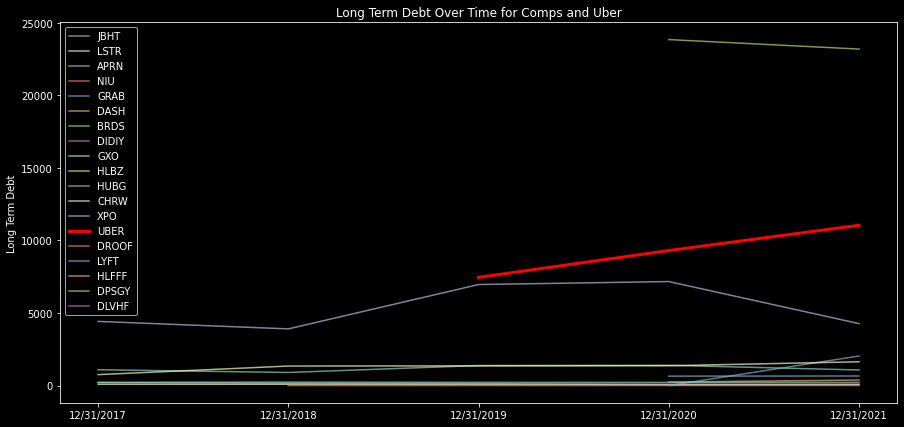

In [15]:
#group by tic and plot dltt over time for each tic; if company is uber plot in red
plt.rcParams['figure.figsize'] = [15, 7]
for tic in comp_financials['tic'].unique():
    df = comp_financials[comp_financials['tic'] == tic]
    if tic == 'UBER':
        plt.plot(df['datadate'], df['dltt'], color='red', linewidth = 3, label=tic)
    else:
        plt.plot(df['datadate'], df['dltt'], label=tic, alpha = 0.7)
plt.title('Long Term Debt Over Time for Comps and Uber')
plt.ylabel('Long Term Debt')
plt.legend(loc='best')
plt.show()


#### Assumption II: Constant Debt/Equity Ratio

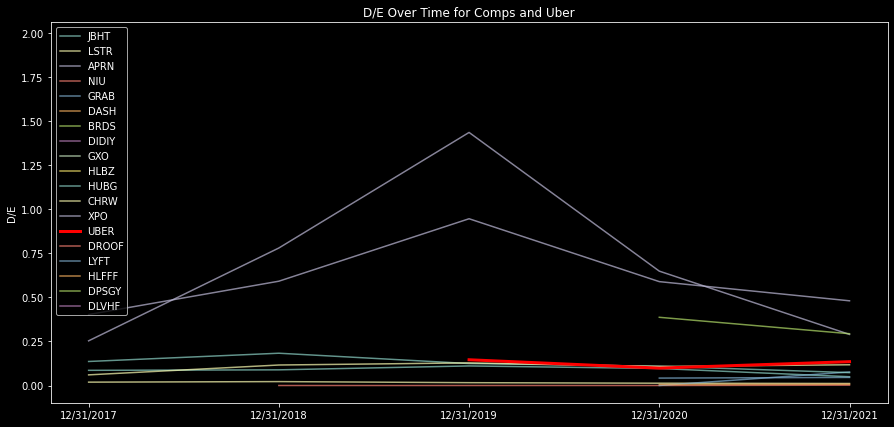

In [16]:
#group by tic and plot dltt over time for each tic; if company is uber plot in red
for tic in comp_financials['tic'].unique():
    df = comp_financials[comp_financials['tic'] == tic]
    if tic == 'UBER':
        plt.plot(df['datadate'], df['dltt'] / (df['csho'] * df['prcc_c']), color='red', linewidth = 3, label=tic)
    else:
        plt.plot(df['datadate'], df['dltt'] / (df['csho'] * df['prcc_c']), alpha=0.7, label=tic)
plt.title('D/E Over Time for Comps and Uber')
plt.ylabel('D/E')
plt.legend(loc='best')
plt.show()



To determine which capital structure assumption to make, we examined up to five years of historical data (when available) for each of the comparable companies as well as Uber to determine which was more appropriate. For the comparables without annual financials data available on WRDS, we found information on their 10k statements to supplement our analysis. Given the plots above of D and D/E over time for both Uber and the comps, we determined that both assumptions would be fairly reasonable as the majority of the comps plotted exhibit flat curves over time in both cases. Despite this, we chose to utilize Assumption II (constant D/E ratio), because we found that a few of the comps we identified likely have debt betas that are non-zero. Because the plot of D/E over time is flat for all but two firms, we feel that this approach is valid. Our method for determining the debt betas is described in the section below when we apply the Assumtion II formula to unlever the comp betas.

### Get the Debt Betas for each of the Comps and Uber


#### Step 1: Get the Equity Betas of Comps (2 years, weekly)

##### S&P 500 Data

In [17]:
# download S&P 500 data
sp500 = yf.download('^GSPC', start='2020-10-17', end='2022-10-17', interval='1wk')
sp500 = sp500.dropna()
sp500 = sp500.reset_index()

# get the weekly returns
sp500['weekly_return'] = sp500['Adj Close'].pct_change()
sp500 = sp500.dropna()

[*********************100%***********************]  1 of 1 completed


##### SCL Analysis for all Comps

In [18]:
#function to calculate the weekly returns for a given ticker (2 year time frame)
def beta(ticker, start, end, interval):
    # get data
    data = yf.download(ticker, start=start, end=end, interval=interval)
    data = data.dropna()
    data = data.reset_index()
    
    # calculate weekly returns
    data['weekly_return'] = data['Adj Close'].pct_change()
    
    # drop na
    data = data.dropna()
    
    # merge with sp500 data on date
    data = data.merge(sp500, on='Date', suffixes=('', '_sp500'))

    # run a regression
    X = data['weekly_return_sp500']
    y = data['weekly_return']

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    
    return model.params[1]

In [19]:
# List of Comps for each Business Segment

mobility = ['LYFT', 'DIDIY', 'GRAB', 'BRDS', 'HLBZ', 'NIU']
delivery = ['DASH', 'DROOF', 'DLVHF', 'HLFFF', 'APRN']
freight = ['CHRW', 'XPO', 'DPSGY', 'GXO', 'JBHT', 'HUBG', 'LSTR']

##### Mobility Betas

In [20]:
mobility_beta = pd.DataFrame()

for ticker in mobility:
    mobility_beta[ticker] = [beta(ticker, '2020-10-17', '2022-10-17', '1wk')]

mobility_beta = mobility_beta.T
mobility_beta.columns = ['Mobility Equity Beta']

mobility_beta

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Mobility Equity Beta
LYFT,1.757576
DIDIY,2.458666
GRAB,1.293262
BRDS,0.775504
HLBZ,1.420304
NIU,1.430427


##### Delivery Betas

In [21]:
delivery_beta = pd.DataFrame()

for ticker in delivery:
    delivery_beta[ticker] = [beta(ticker, '2020-10-17', '2022-10-17', '1wk')]

delivery_beta = delivery_beta.T
delivery_beta.columns = ['Delivery Equity Beta']
delivery_beta

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Delivery Equity Beta
DASH,1.732550
DROOF,0.570273
DLVHF,1.411151
HLFFF,0.813275
APRN,1.152158


##### Freight Betas

In [22]:
freight_beta = pd.DataFrame()

for ticker in freight:
    freight_beta[ticker] = [beta(ticker, '2020-10-17', '2022-10-17', '1wk')]

freight_beta = freight_beta.T
freight_beta.columns = ['Freight Equity Beta']
freight_beta

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Freight Equity Beta
CHRW,0.803364
XPO,1.405871
DPSGY,1.003579
GXO,1.635069
JBHT,0.978679
HUBG,0.944203
LSTR,0.721046


#### Step 2: Unlever the Betas of the Comps (Assumption II) and Cash Adjust Them

<table>
<tr>
<th colspan=4>Penny Stocks (Also < $5.00)</th>
</tr>
<tr>
<th>Segment</th>
<th>Ticker</th>
<th>Company</th>
<th>Price</th>
</tr>
<tr>
<td>Delivery</td>
<td>DROOF</td>
<td>Deliveroo</td>
<td>$1.00</td>
</tr>
<tr>
<td>Delivery</td>
<td>APRN</td>
<td>Blue Apron</td>
<td>$2.53</td>
</tr>
<tr>
<td>Mobility</td>
<td>DIDIY</td>
<td>Didi Global</td>
<td>$1.64</td>
</tr>
<tr>
<td>Mobility</td>
<td>GRAB</td>
<td>Grab Holdings</td>
<td>$2.40</td>
</tr>
<tr>
<td>Mobility</td>
<td>BRDS</td>
<td>Bird Global</td>
<td>$0.37</td>
</tr>
<tr>
<td>Mobility</td>
<td>HLBZ</td>
<td>Helbiz</td>
<td>$0.28</td>
</tr>
<tr>
<td>Mobility</td>
<td>NIU</td>
<td>Niu Technologies</td>
<td>$2.81</td>
</tr>
</table>

We made the assumption that companies under \$5.00 per share are penny stocks and therefore they will have a higher risk of defaulting. At their IPO these companies are often valued at a higher price than their much lower current price, so this decreased price is a sign of the company not doing well. For example at one point Bird Scooters was trading at \$8.40 per share at its IPO, while it is now trading at \$0.37 per share, this is a decline in their market cap by 95.6% from \$2.2 billion to \$97.02 million. As seen in the Bird example this is a clear sign that the company is struggling and could have trouble paying back their debt. Based on this assumption we set the debt beta for these penny stocks to 0.5 because we assumed their investment grade was most likely in the sub-investment grade range which usually have debt betas between 0.3 and 0.5. Only five of the comparable companies had debt grades listed in WRDS and all five of these were investment grade. Thus we made our assumption that the debt betas for the other comparable companies were investment grade, unless they were under \$5.00 per share.

In [23]:
# get the relevant information for 2021 for each ticker
comp_2021 = comp_financials[['dltt', 'csho', 'prcc_c', 'che', 'fyear', 'tic', 'conm']].sort_values(by='fyear', ascending=False).drop_duplicates(subset='tic', keep='first')

# Add in the Beta Debt, MV Equity, and D/E Ratio for each Comp as of 2021
comp_2021['beta_debt'] = 0

penny = ['DROOF', 'APRN', 'DIDIY', 'GRAB', 'BRDS', 'HLBZ', 'NIU']
comp_2021.loc[comp_2021['tic'].isin(penny), 'beta_debt'] = 0.5

comp_2021['mv_equity'] = comp_2021['csho'] * comp_2021['prcc_c']
comp_2021['de_ratio'] = comp_2021['dltt'] / comp_2021['mv_equity']

In [24]:
# Compute the Unlevered Beta and Cash Adjusted Beta for each Comp

for index, row in comp_2021.iterrows():
    tic = row['tic']
    if tic in mobility:
        beta_equity = mobility_beta.loc[tic, 'Mobility Equity Beta']
        comp_2021.loc[index, 'segment'] = 'Mobility'
    elif tic in delivery:
        beta_equity = delivery_beta.loc[tic, 'Delivery Equity Beta']
        comp_2021.loc[index, 'segment'] = 'Delivery'
    elif tic in freight:
        beta_equity = freight_beta.loc[tic, 'Freight Equity Beta']
        comp_2021.loc[index, 'segment'] = 'Freight'
    else:
        beta_equity = 0
    comp_2021.loc[index, 'beta_equity'] = beta_equity

comp_2021['beta_unlevered'] = (comp_2021['beta_equity'] / (1 + comp_2021['de_ratio'])) + ((comp_2021['de_ratio'] * comp_2021['beta_debt']) / (1 + comp_2021['de_ratio']))
comp_2021['cash_adj_beta'] = comp_2021['beta_unlevered'] / (1 - ((comp_2021['che']) / (comp_2021['dltt'] + comp_2021['mv_equity'])))

comp_2021.head(5)


,dltt,csho,prcc_c,che,fyear,tic,conm,beta_debt,mv_equity,de_ratio,segment,beta_equity,beta_unlevered,cash_adj_beta
26,18.057,30.515,5.49,21.143,2021,HLBZ,HELBIZ INC,0.5,167.52735,0.107785,Mobility,1.420304,1.330761,1.501863
18,2.192,76.840,16.11,204.908,2021,NIU,NIU TECHNOLOGIES -ADR,0.5,1237.89240,0.001771,Mobility,1.430427,1.428783,1.711603
51,23186.000,1232.450,64.08,3531.000,2021,DPSGY,DHL,0.0,78975.39600,0.293585,Freight,1.003579,0.775812,0.803587
50,175.000,173.710,19.05,467.200,2021,HLFFF,HELLO FRESH,0.0,3309.17550,0.052883,Delivery,0.813275,0.772426,0.892042
46,655.173,334.724,42.73,457.325,2021,LYFT,LYFT,0.0,14302.75652,0.045807,Mobility,1.757576,1.680592,1.733595


#### Step 3: Get the Average Unlevered/Cash Adjusted Beta for Each Sector

In [25]:
average_unlevered = comp_2021.groupby('segment')['cash_adj_beta'].mean()
average_unlevered

segment
Delivery    1.125938
Freight     0.927381
Mobility    1.906259
Name: cash_adj_beta, dtype: float64

#### Step 4: Uber Analysis with Comps

##### Segment Multipliers (EV/Sales Sourced from Revenue Multiples by Sector (US) - Stern)
- Delivery: Software (System & Application) (12.84)
- Freight: Transportation (1.52)
- Mobility: Software (System & Application) (12.84)

In [26]:
# Uber Revenue by Segment ['delivery', 'freight', 'mobility']
uber_revenue = [8632000000, 2132000000, 6953000000]

# Uber Multipliers by Segment ['delivery', 'freight', 'mobility']
segment_multipliers = [12.84, 1.52, 12.84]

In [27]:
final_df = pd.DataFrame()
final_df['Multiplier'] = segment_multipliers
final_df['Revenue'] = uber_revenue
final_df['Implied Enterprise Value'] = final_df['Multiplier'] * final_df['Revenue']
final_df['Segment Weight'] = final_df["Implied Enterprise Value"] / final_df["Implied Enterprise Value"].sum()
final_df['Unlevered Beta'] = average_unlevered.values
final_df['Weighted Beta Component'] = final_df['Segment Weight'] * final_df['Unlevered Beta']

final_df

,Multiplier,Revenue,Implied Enterprise Value,Segment Weight,Unlevered Beta,Weighted Beta Component
0,12.84,8632000000,1.108349e+11,0.545039,1.125938,0.613680
1,1.52,2132000000,3.240640e+09,0.015936,0.927381,0.014779
2,12.84,6953000000,8.927652e+10,0.439024,1.906259,0.836894


##### Get the Unlevered Beta for Uber

In [28]:
uber_unlevered_beta_cashadj = final_df['Weighted Beta Component'].sum()
print('Uber Unlevered Beta (Cash Adjusted):', round(uber_unlevered_beta_cashadj, 4))

Uber Unlevered Beta (Cash Adjusted): 1.4654


##### Undo Cash Adjustment of Uber's Unlevered Beta

In [29]:
uber = comp_2021[comp_2021['tic'] == 'UBER']
uber_unlevered_beta = uber_unlevered_beta_cashadj * (1 - ((uber['che']) / (uber['dltt'] + uber['mv_equity'])))
uber_unlevered_beta = uber_unlevered_beta.values[0]
print('Uber Unlevered Beta:', round(uber_unlevered_beta, 4))

Uber Unlevered Beta: 1.3875


##### Relever Uber's Beta to Get Final Equity Beta (Assumption II)

In [30]:
levered_beta = uber_unlevered_beta * (1 + uber['de_ratio'])
levered_beta = levered_beta.values[0]

print('Uber Levered Beta:', round(levered_beta, 4))

Uber Levered Beta: 1.5749


## Part III: Comparison of SCL vs. Comps Methods

In the end, we got an estimated βE of 1.6104 via the SCL regression analysis and an estimated βE of about 1.5749 from the comparable companies analysis. We were quite surprised as to how close these two estimates were especially regarding the difficult nature in finding appropriate comps. The estimate βE of 1.5749 from the comps analysis was indeed well within the 95% confidence interval of (1.0961, 2.1247) that we got when doing our regression analysis (though this interval is quite large and not all that informative). A logical next step would be to blend these two estimates to get a single estimated βE. Such an approach would be particularly important if the two estimates were significantly different from one another. The weight placed on the estimated βE from SCL in the blended βE would depend on how confident one is that the past performance of the company in question is reflective of expected future performance. Additionally, the weight placed on the estimated βE from comps analysis in the blended βE would depend on how confident one is that appropriate comps were gathered. 